In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
df = pd.read_csv('model1.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Name                   100 non-null    object 
 1   DataBreachSource       100 non-null    object 
 2   Title                  95 non-null     object 
 3   Channel                100 non-null    object 
 4   Sector                 100 non-null    object 
 5   Author                 42 non-null     object 
 6   VaderSentiment         100 non-null    object 
 7   DataType               80 non-null     object 
 8   PositiveCount          100 non-null    int64  
 9   NegativeCount          100 non-null    int64  
 10  PosNegRatio            100 non-null    float64
 11  PosTotalRatio          100 non-null    float64
 12  AvgPositiveConf        100 non-null    float64
 13  AvgNegativeConf        100 non-null    float64
 14  WordCount              100 non-null    int64  
 15  Sentenc

In [24]:
df.head()

,Name,DataBreachSource,Title,Channel,Sector,Author,VaderSentiment,DataType,PositiveCount,NegativeCount,...,FAQKeywordCount,AvgWordLength,AvgSentenceLength,UniqueWordCount,StopWordCount,CharCount,PunctuationCount,EmailTagCount,TimelagGroupEncoded,CombinedLabel
0,PageUp People,Malicious or criminal attack,Unauthorised Activity on IT System,Website,Information media and telecommunications,Chief Executive Officer,Positive,"name, street address, email address, telephone...",7,3,...,2,5.240566,21.200000,150,91,1349,21,0,0.45,2.0
1,Canva,Malicious or criminal attack,Canva Security Incident  May 24 FAQs,Website,Information media and telecommunications,Head of Security,Neutral,"username, name, email address, country, city, ...",23,24,...,0,4.885478,19.250000,440,376,5118,111,0,0.45,1.0
2,Australian National University,Malicious or criminal attack,Message from the Vice-Chancellor,Website,Education and training,Vice-Chancellor,Positive,"name, address, date of birth, phone number, pe...",21,7,...,1,5.143141,16.833333,281,229,3206,61,1,0.17,2.0
3,Australian Catholic University,Malicious or criminal attack,Cyber attack on ACU IT systems,Website,Education and training,Acting Vice-Chancellor,Positive,"email account, calendar, bank account details",7,9,...,0,5.392523,20.619048,255,169,2799,49,1,0.45,1.0
4,NAB,Human error,NAB apologises to customers for data breach,Website,Financial and insurance services,NaN,Positive,"customer name, date of birth, contact details,...",14,5,...,0,5.308357,14.708333,217,134,2274,52,0,0.45,1.0


### Feature Engineering & Feature Transformation

#### Transform CombinedLabel

In [25]:
# Rename the column
df.rename(columns={'CombinedLabel': 'LevelOfDetail'}, inplace=True)

# Convert the class label from int to string
df['LevelOfDetail'] = df['LevelOfDetail'].astype(str)

In [26]:
label = {'1.0' : 0, '2.0': 1, '3.0': 2} # 0 FullTranparency, 1 Guarded, 2 Opacity

for dataset in [df]:
    dataset['LevelOfDetail'] = dataset['LevelOfDetail'].map(label)

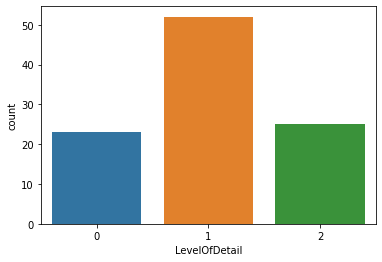

In [27]:
sns.countplot(x='LevelOfDetail', data=df)
plt.show()

In [28]:
df['LevelOfDetail'].value_counts()

1    52
2    25
0    23
Name: LevelOfDetail, dtype: int64

#### Frequency Encoding Categorical features

In [29]:
nominal_col = ['DataBreachSource', 'Channel', 'Sector', 'VaderSentiment']

def freq_encoding(df, nominal_cols):
    for col in nominal_cols:
        # generate the frequency encoding for each categorical value in the target column
        fr_enc = (df.groupby(col).size()) / len(df)

        # # print the encoding values
        # print(fr_enc)

        # create a new column that apply frequency encoding to Age Group
        df[col+"_Encoded"] = df[col].apply(lambda x : fr_enc[x])
        
freq_encoding(df, nominal_col)

In [30]:
df['Sector_Encoded'].value_counts()

0.24    24
0.07    14
0.13    13
0.09     9
0.04     8
0.08     8
0.02     8
0.03     6
0.01     5
0.05     5
Name: Sector_Encoded, dtype: int64

#### Author column

In [31]:
df['Author'].value_counts(dropna=False)

NaN                                   58
Chief Executive Officer               11
Company's Name                         5
Board                                  5
Vice-Chancellor                        3
Managing Director                      2
Chief Information Security Officer     1
Community moderator                    1
VP of Product Management               1
Chief Digital Officer                  1
Vice President Media Relations         1
Chairman                               1
Media contact                          1
Chief Financial Officer                1
Principal                              1
Head of Security                       1
Chief Security Officer                 1
Acting Chief Executive                 1
General Secretary                      1
Company Secretary                      1
Acting Vice-Chancellor                 1
General Manager Corporate HR / IR      1
Name: Author, dtype: int64

In [32]:
isinstance(df['Author'][4], str)

False

In [33]:
# Create new column if there is an author mentioned
df['AuthorMention'] = df['Author'].apply(lambda x: 1 if isinstance(x, str) else 0)

In [34]:
df['AuthorMention'].value_counts()

0    58
1    42
Name: AuthorMention, dtype: int64

#### Title column

In [35]:
df['Title'].head()

0             Unauthorised Activity on IT System
1          Canva Security Incident  May 24 FAQs
2               Message from the Vice-Chancellor
3                 Cyber attack on ACU IT systems
4    NAB apologises to customers for data breach
Name: Title, dtype: object

In [36]:
import string
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [37]:
# Ref: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

# Lemmatize with POS Tag
from nltk.corpus import wordnet
# nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [38]:
def preprocess(text):
    try: 
        # split into sentences
        sentences = sent_tokenize(text)

        # split into words
        tokens = word_tokenize(text)

        # convert to lower case
        tokens = [w.lower() for w in tokens]

        # remove punctuation from each word
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]

        # remove remaining tokens that are not alphabetic
        words = [word for word in stripped if word.isalpha()]

        # filter out stop words
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if not w in stop_words]

        # Lemmatise the tokens
        lemmatizer = WordNetLemmatizer()
        lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]

        # Join the tokens back into a string
        processed_text = ' '.join(lemmatized_tokens)
        return processed_text
    except TypeError:
        return ""

In [39]:
df['Title_nltk'] = df['Title'].apply(lambda x: preprocess(x))

In [40]:
df['Title_nltk'].head()

0           unauthorised activity system
1        canva security incident may faq
2                 message vicechancellor
3                cyber attack acu system
4    nab apologises customer data breach
Name: Title_nltk, dtype: object

##### Topic modelling for Title

In [41]:
# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# Ref: https://www.studytonight.com/post/scikitlearn-countvectorizer-in-nlp

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# LATENT DIRICHLET ALLOCATION (LDA) TOPIC MODELLING

tf_vectorizer = CountVectorizer(max_df=0.90, min_df=25, max_features=5000)
tf = tf_vectorizer.fit_transform(df['Title_nltk'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names_out()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix

lda_model = LatentDirichletAllocation(n_components=5,learning_method='online',max_iter=50, random_state=0).fit(tf)
no_top_words = 2
def display_topics(model, feature_names, no_top_words):
    for topix_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topix_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words-1:-1]]))
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0:
data incident
Topic 1:
data incident
Topic 2:
incident data
Topic 3:
incident data
Topic 4:
incident data


Summary: All titles revolve around the topic: "data incident."

In [42]:
df['Title'].value_counts(dropna=False)

NaN                                                5
Data Breach                                        2
Cyber Security Incident                            2
Privacy breach                                     2
Cyber Incident                                     2
                                                  ..
IMPORTANT INFORMATION: CTARS DATA BREACH           1
AIS privacy incident                               1
Unauthorised disclosure of personal information    1
Frontier Software Cyber Incident                   1
Appen Advises Of IT Security Incident              1
Name: Title, Length: 92, dtype: int64

In [43]:
# Create new column if there is a title for the statement
df['TitleMention'] = df['Title'].apply(lambda x: 1 if isinstance(x, str) else 0)

In [44]:
df['TitleMention'].value_counts(dropna=False)

1    95
0     5
Name: TitleMention, dtype: int64

#### Datatype

In [45]:
df['DataType']

0     name, street address, email address, telephone...
1     username, name, email address, country, city, ...
2     name, address, date of birth, phone number, pe...
3         email account, calendar, bank account details
4     customer name, date of birth, contact details,...
                            ...                        
95    name, address, country, phone, email, hashed p...
96                    name, phone number, email address
97    name, email address, mobile, Landline phone nu...
98    personal information of Aristocrate employees ...
99    customer and crowd name, company name, email a...
Name: DataType, Length: 100, dtype: object

In [46]:
df['DataType'][0]

'name, street address, email address, telephone number, employment information, gender, date of birth, middle name, nationality, job references, job information, system communication, approval request, agency contacts login detail'

In [47]:
set(df['DataType'][1].split(', '))

{'OAuth login token',
 'city',
 'country',
 'credit card',
 'cryptographically protected password',
 'email address',
 'homepage URL',
 'name',
 'payment data',
 'username'}

In [48]:
len(set(df['DataType'][1].split(', ')))

10

In [49]:
# 20 records without datatype mentioned
df['DataType'].value_counts(dropna=False)

NaN                                                                                                                                                                                                                                      20
name, email address, phone number, customer chat transcripts                                                                                                                                                                              2
                                                                                                                                                                                                                                          2
email address, phone number                                                                                                                                                                                                               2
name, street address, email address, telephone number, e

In [50]:
isinstance(df['DataType'][7], str)

False

In [51]:
df['DataTypeCount'] = df['DataType'].apply(lambda x: len(set(x.split(', '))) if isinstance(x, str) else 0)

In [52]:
df['DataTypeCount'].value_counts()

0     20
1     17
2     12
4      8
7      8
3      7
6      7
9      4
10     4
5      4
12     3
14     1
8      1
18     1
13     1
22     1
11     1
Name: DataTypeCount, dtype: int64

In [53]:
df.head()

,Name,DataBreachSource,Title,Channel,Sector,Author,VaderSentiment,DataType,PositiveCount,NegativeCount,...,TimelagGroupEncoded,LevelOfDetail,DataBreachSource_Encoded,Channel_Encoded,Sector_Encoded,VaderSentiment_Encoded,AuthorMention,Title_nltk,TitleMention,DataTypeCount
0,PageUp People,Malicious or criminal attack,Unauthorised Activity on IT System,Website,Information media and telecommunications,Chief Executive Officer,Positive,"name, street address, email address, telephone...",7,3,...,0.45,1,0.75,0.79,0.24,0.77,1,unauthorised activity system,1,14
1,Canva,Malicious or criminal attack,Canva Security Incident  May 24 FAQs,Website,Information media and telecommunications,Head of Security,Neutral,"username, name, email address, country, city, ...",23,24,...,0.45,0,0.75,0.79,0.24,0.19,1,canva security incident may faq,1,10
2,Australian National University,Malicious or criminal attack,Message from the Vice-Chancellor,Website,Education and training,Vice-Chancellor,Positive,"name, address, date of birth, phone number, pe...",21,7,...,0.17,1,0.75,0.79,0.13,0.77,1,message vicechancellor,1,9
3,Australian Catholic University,Malicious or criminal attack,Cyber attack on ACU IT systems,Website,Education and training,Acting Vice-Chancellor,Positive,"email account, calendar, bank account details",7,9,...,0.45,0,0.75,0.79,0.13,0.77,1,cyber attack acu system,1,3
4,NAB,Human error,NAB apologises to customers for data breach,Website,Financial and insurance services,NaN,Positive,"customer name, date of birth, contact details,...",14,5,...,0.45,0,0.18,0.79,0.09,0.77,0,nab apologises customer data breach,1,4


### Feature Selection

In [54]:
# Copy certain columns to create a new DataFrame
selected_columns = ['AuthorMention', 'TitleMention', 'DataTypeCount',
    'DataBreachSource_Encoded', 'Channel_Encoded', 'Sector_Encoded', 'VaderSentiment_Encoded',
    'PositiveCount', 'NegativeCount', 'PosNegRatio', 'PosTotalRatio', 'AvgPositiveConf', 'AvgNegativeConf', 
                                              'WordCount', 'SentenceCount', 'ReadingEase', 'Flesch-KincaidGrade', 'HyperlinksCount', 'CyberKeywordCount', 'AuthorityKeywordCount',  'FAQKeywordCount', 
                                             'AvgWordLength', 'AvgSentenceLength', 
    'UniqueWordCount', 'StopWordCount', 'CharCount', 'PunctuationCount', 'EmailTagCount', 'TimelagGroupEncoded',
    'LevelOfDetail']  
# Test modelling for class "LevelDetail"
df = df[selected_columns].copy()

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   AuthorMention             100 non-null    int64  
 1   TitleMention              100 non-null    int64  
 2   DataTypeCount             100 non-null    int64  
 3   DataBreachSource_Encoded  100 non-null    float64
 4   Channel_Encoded           100 non-null    float64
 5   Sector_Encoded            100 non-null    float64
 6   VaderSentiment_Encoded    100 non-null    float64
 7   PositiveCount             100 non-null    int64  
 8   NegativeCount             100 non-null    int64  
 9   PosNegRatio               100 non-null    float64
 10  PosTotalRatio             100 non-null    float64
 11  AvgPositiveConf           100 non-null    float64
 12  AvgNegativeConf           100 non-null    float64
 13  WordCount                 100 non-null    int64  
 14  SentenceCou

In [56]:
df.head()

,AuthorMention,TitleMention,DataTypeCount,DataBreachSource_Encoded,Channel_Encoded,Sector_Encoded,VaderSentiment_Encoded,PositiveCount,NegativeCount,PosNegRatio,...,FAQKeywordCount,AvgWordLength,AvgSentenceLength,UniqueWordCount,StopWordCount,CharCount,PunctuationCount,EmailTagCount,TimelagGroupEncoded,LevelOfDetail
0,1,1,14,0.75,0.79,0.24,0.77,7,3,2.333333,...,2,5.240566,21.200000,150,91,1349,21,0,0.45,1
1,1,1,10,0.75,0.79,0.24,0.19,23,24,0.958333,...,0,4.885478,19.250000,440,376,5118,111,0,0.45,0
2,1,1,9,0.75,0.79,0.13,0.77,21,7,3.000000,...,1,5.143141,16.833333,281,229,3206,61,1,0.17,1
3,1,1,3,0.75,0.79,0.13,0.77,7,9,0.777778,...,0,5.392523,20.619048,255,169,2799,49,1,0.45,0
4,0,1,4,0.18,0.79,0.09,0.77,14,5,2.800000,...,0,5.308357,14.708333,217,134,2274,52,0,0.45,0


In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df.iloc[:,:-1].values
X_train = df.drop(columns='LevelOfDetail')
y_train = df['LevelOfDetail']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
pca = PCA()
X_pca = pca.fit_transform(X_train_scaled)
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
n_to_reach_95 = X.shape[1] - n_over_95 + 1
print("Number features: {}\tTotal Variance Explained: {}".format(n_to_reach_95, total_explained_variance[n_to_reach_95-1]))

Number features: 16	Total Variance Explained: 0.9579776542169016


In [58]:
# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import model_selection, tree, preprocessing, datasets, metrics, linear_model
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, confusion_matrix

import math, time, random, datetime

C:\Apps\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Performance Metrics:
Naive Bayes: 
 Accuracy: 66.000% 
 Precision: 0.633 
 Recall: 0.600 
 F1 Score: 0.611
SVC_linear: 
 Accuracy: 68.000% 
 Precision: 0.663 
 Recall: 0.618 
 F1 Score: 0.626
SVC_rbf: 
 Accuracy: 52.000% 
 Precision: 0.173 
 Recall: 0.333 
 F1 Score: 0.228
Random Forest: 
 Accuracy 100.000% 
 Precision: 1.000 
 Recall: 1.000 
 F1 Score: 1.000

Feature Weights:
SVC weights: [[ 0.20497671 -0.11729823 -0.09723671  0.09073002  0.17903575 -0.13097836
  -0.04172817  0.36883514  0.32765295  0.02229256  0.21210448 -0.14675051
  -0.0454492  -0.07507494 -0.01143145 -0.02822594]
 [ 0.18835244 -0.00548521 -0.18200582 -0.35619232  0.27700468  0.03733779
   0.0648966   0.33941541 -0.04006368  0.23220456 -0.01137768 -0.11716129
  -0.02534692 -0.03403468 -0.01961385 -0.13222401]
 [ 0.16738298  0.00271377 -0.14029712 -0.48462963  0.30943884  0.18210763
  -0.00506665  0.26975309 -0.28988886  0.14921515 -0.21994871  0.37917339
   0.00672784 -0.04424747 -0.15244072 -0.13745793]]
Random Fo

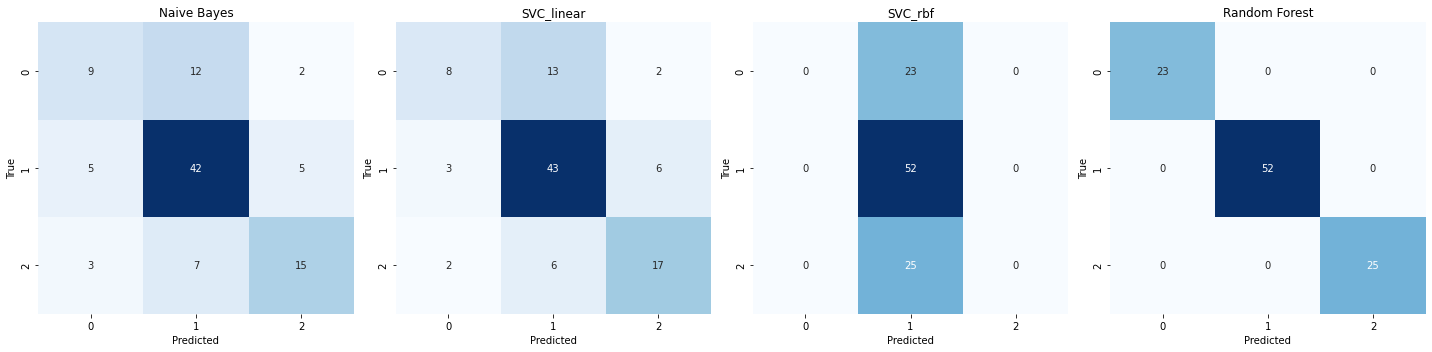

In [59]:
y_train = df['LevelOfDetail']
X_train = df.drop('LevelOfDetail', axis=1)

def create_pipeline(X_train, y_train): 
    # Create transformers
    scaler = StandardScaler()
    pca = PCA(n_components=16)

    # Fit transformers
    X_train_scaled = scaler.fit_transform(X_train)
    X_train_pca = pca.fit_transform(X_train_scaled)

    # Create models
    nb = GaussianNB()
    svc = SVC(kernel='linear')
    svc_r = SVC(kernel='rbf')
    rf = RandomForestClassifier()

    # Fit models using grid search
    nb_grid = GridSearchCV(nb, param_grid={}, cv=10)
    nb_grid.fit(X_train_pca, y_train)
    
    param_grid_svc = {'C': [0.1, 1, 10],
                      'gamma': [0.001, 0.01, 0.1]}
    svc_grid = GridSearchCV(svc, param_grid=param_grid_svc, cv=10)
    svc_grid.fit(X_train_pca, y_train)
    
    param_grid_svc_r = {'C': [1, 10, 100, 1000],
                        'gamma': [1e-3, 1e-4]}
    svc_r_grid = GridSearchCV(svc_r, param_grid=param_grid_svc_r, cv=10)
    svc_r_grid.fit(X_train_pca, y_train)

    param_grid_rf = {'n_estimators': [100, 250, 500, 750, 1000],
                     'max_depth': [10, 50, 100]}
    rf_grid = GridSearchCV(rf, param_grid=param_grid_rf, cv=10)
    rf_grid.fit(X_train_pca, y_train)

    # Make predictions
    y_pred_nb = nb_grid.predict(X_train_pca)
    y_pred_svc = svc_grid.predict(X_train_pca)
    y_pred_svc_r = svc_r_grid.predict(X_train_pca)
    y_pred_rf = rf_grid.predict(X_train_pca)

    # Calculate performance metrics
    accuracy_nb = accuracy_score(y_train, y_pred_nb)*100
    accuracy_svc = accuracy_score(y_train, y_pred_svc)*100
    accuracy_svc_r = accuracy_score(y_train, y_pred_svc_r)*100
    accuracy_rf = accuracy_score(y_train, y_pred_rf)*100

    precision_nb = precision_score(y_train, y_pred_nb, average='macro')
    precision_svc = precision_score(y_train, y_pred_svc, average='macro')
    precision_svc_r = precision_score(y_train, y_pred_svc_r, average='macro')
    precision_rf = precision_score(y_train, y_pred_rf, average='macro')

    recall_nb = recall_score(y_train, y_pred_nb, average='macro')
    recall_svc = recall_score(y_train, y_pred_svc, average='macro')
    recall_svc_r = recall_score(y_train, y_pred_svc_r, average='macro')
    recall_rf = recall_score(y_train, y_pred_rf, average='macro')

    f1_nb = f1_score(y_train, y_pred_nb, average='macro')
    f1_svc = f1_score(y_train, y_pred_svc, average='macro')
    f1_svc_r = f1_score(y_train, y_pred_svc_r, average='macro')
    f1_rf = f1_score(y_train, y_pred_rf, average='macro')
    
     # Extract feature weights for models
    feature_weights = {}
    if hasattr(svc_grid.best_estimator_, 'coef_'):
        feature_weights['SVC'] = svc_grid.best_estimator_.coef_
    if hasattr(svc_r_grid.best_estimator_, 'coef_'):
        feature_weights['SVC_rbf'] = svc_r_grid.best_estimator_.coef_
    if hasattr(rf_grid.best_estimator_, 'feature_importances_'):
        feature_weights['Random Forest'] = rf_grid.best_estimator_.feature_importances_

    # Print the results
    print("Performance Metrics:")
    print("Naive Bayes:","\n Accuracy: %.3f%%" % accuracy_nb, "\n Precision: %.3f" % precision_nb, "\n Recall: %.3f" % recall_nb, "\n F1 Score: %.3f" % f1_nb)
    print("SVC_linear:", "\n Accuracy: %.3f%%" % accuracy_svc, "\n Precision: %.3f" % precision_svc, "\n Recall: %.3f" % recall_svc, "\n F1 Score: %.3f" % f1_svc)
    print("SVC_rbf:", "\n Accuracy: %.3f%%" % accuracy_svc_r, "\n Precision: %.3f" % precision_svc_r, "\n Recall: %.3f" % recall_svc_r, "\n F1 Score: %.3f" % f1_svc_r)
    print("Random Forest:","\n Accuracy %.3f%%" % accuracy_rf, "\n Precision: %.3f" % precision_rf, "\n Recall: %.3f" % recall_rf, "\n F1 Score: %.3f" % f1_rf)
    
    print("\nFeature Weights:")
    for model_name, weights in feature_weights.items():
        print(model_name, "weights:", weights)
        
    print("Best Estimator Parameters:")
    print("Naive Bayes:", nb_grid.best_params_)
    print("SVC_linear:", svc_grid.best_params_)
    print("SVC_rbf:", svc_r_grid.best_params_)
    print("Random Forest:", rf_grid.best_params_)
    
    # Calculate and plot confusion matrix
    y_pred_svc = svc_grid.predict(X_train_pca)
    y_pred_svc_r = svc_r_grid.predict(X_train_pca)
    y_pred_rf = rf_grid.predict(X_train_pca)

    cm_nb = confusion_matrix(y_train, y_pred_nb)
    cm_svc = confusion_matrix(y_train, y_pred_svc)
    cm_svc_r = confusion_matrix(y_train, y_pred_svc_r)
    cm_rf = confusion_matrix(y_train, y_pred_rf)

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    sns.heatmap(cm_nb, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.title('Naive Bayes')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.subplot(1, 4, 2)
    sns.heatmap(cm_svc, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.title('SVC_linear')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.subplot(1, 4, 3)
    sns.heatmap(cm_svc_r, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.title('SVC_rbf')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.subplot(1, 4, 4)
    sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.title('Random Forest')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()
    plt.show()
    
    # Return the pipelines
    return nb_grid, svc_grid, svc_r_grid, rf_grid, feature_weights

# Call the function
nb_pipeline, svc_pipeline, svc_r_pipeline, rf_pipeline, feature_weights = create_pipeline(X_train, y_train)


#### 2. Train/Test Split

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn import datasets, preprocessing, svm
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [37]:
X = df.drop(columns='LevelOfDetail')
y = df['LevelOfDetail']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((70, 25), (70,), (30, 25), (30,))

In [38]:
X.head()

,DataBreachSource_Encoded,Channel_Encoded,Sector_Encoded,VaderSentiment_Encoded,PositiveCount,NegativeCount,PosNegRatio,PosTotalRatio,AvgPositiveConf,AvgNegativeConf,...,CyberKeywordCount,AuthorityKeywordCount,FAQKeywordCount,AvgWordLength,AvgSentenceLength,UniqueWordCount,StopWordCount,CharCount,PunctuationCount,EmailTagCount
0,0.75,0.79,0.24,0.77,7,3,2.333333,0.700000,0.980128,0.972266,...,1,0,2,5.240566,21.200000,150,91,1349,21,0
1,0.75,0.79,0.24,0.19,23,24,0.958333,0.489362,0.987493,0.995686,...,4,0,0,4.885478,19.250000,440,376,5118,111,0
2,0.75,0.79,0.13,0.77,21,7,3.000000,0.750000,0.989652,0.995580,...,5,0,1,5.143141,16.833333,281,229,3206,61,1
3,0.75,0.79,0.13,0.77,7,9,0.777778,0.437500,0.997064,0.996481,...,11,4,0,5.392523,20.619048,255,169,2799,49,1
4,0.18,0.79,0.09,0.77,14,5,2.800000,0.736842,0.993265,0.971655,...,0,1,0,5.308357,14.708333,217,134,2274,52,0


In [39]:
X.columns

Index(['DataBreachSource_Encoded', 'Channel_Encoded', 'Sector_Encoded',
       'VaderSentiment_Encoded', 'PositiveCount', 'NegativeCount',
       'PosNegRatio', 'PosTotalRatio', 'AvgPositiveConf', 'AvgNegativeConf',
       'WordCount', 'SentenceCount', 'ReadingEase', 'Flesch-KincaidGrade',
       'HyperlinksCount', 'CyberKeywordCount', 'AuthorityKeywordCount',
       'FAQKeywordCount', 'AvgWordLength', 'AvgSentenceLength',
       'UniqueWordCount', 'StopWordCount', 'CharCount', 'PunctuationCount',
       'EmailTagCount'],
      dtype='object')

#### 3. Standardisation

In [40]:
from sklearn import preprocessing

# apply standardisation to explanatory variables
# Build scaler on the train set
std_scaler = preprocessing.StandardScaler().fit(X_train)

# Standardise the train set
X_train_std = std_scaler.transform(X_train)

# Standardise the test set
X_test_std = std_scaler.transform(X_test)

#### 4. Decision Tree

Accuracy: 0.43


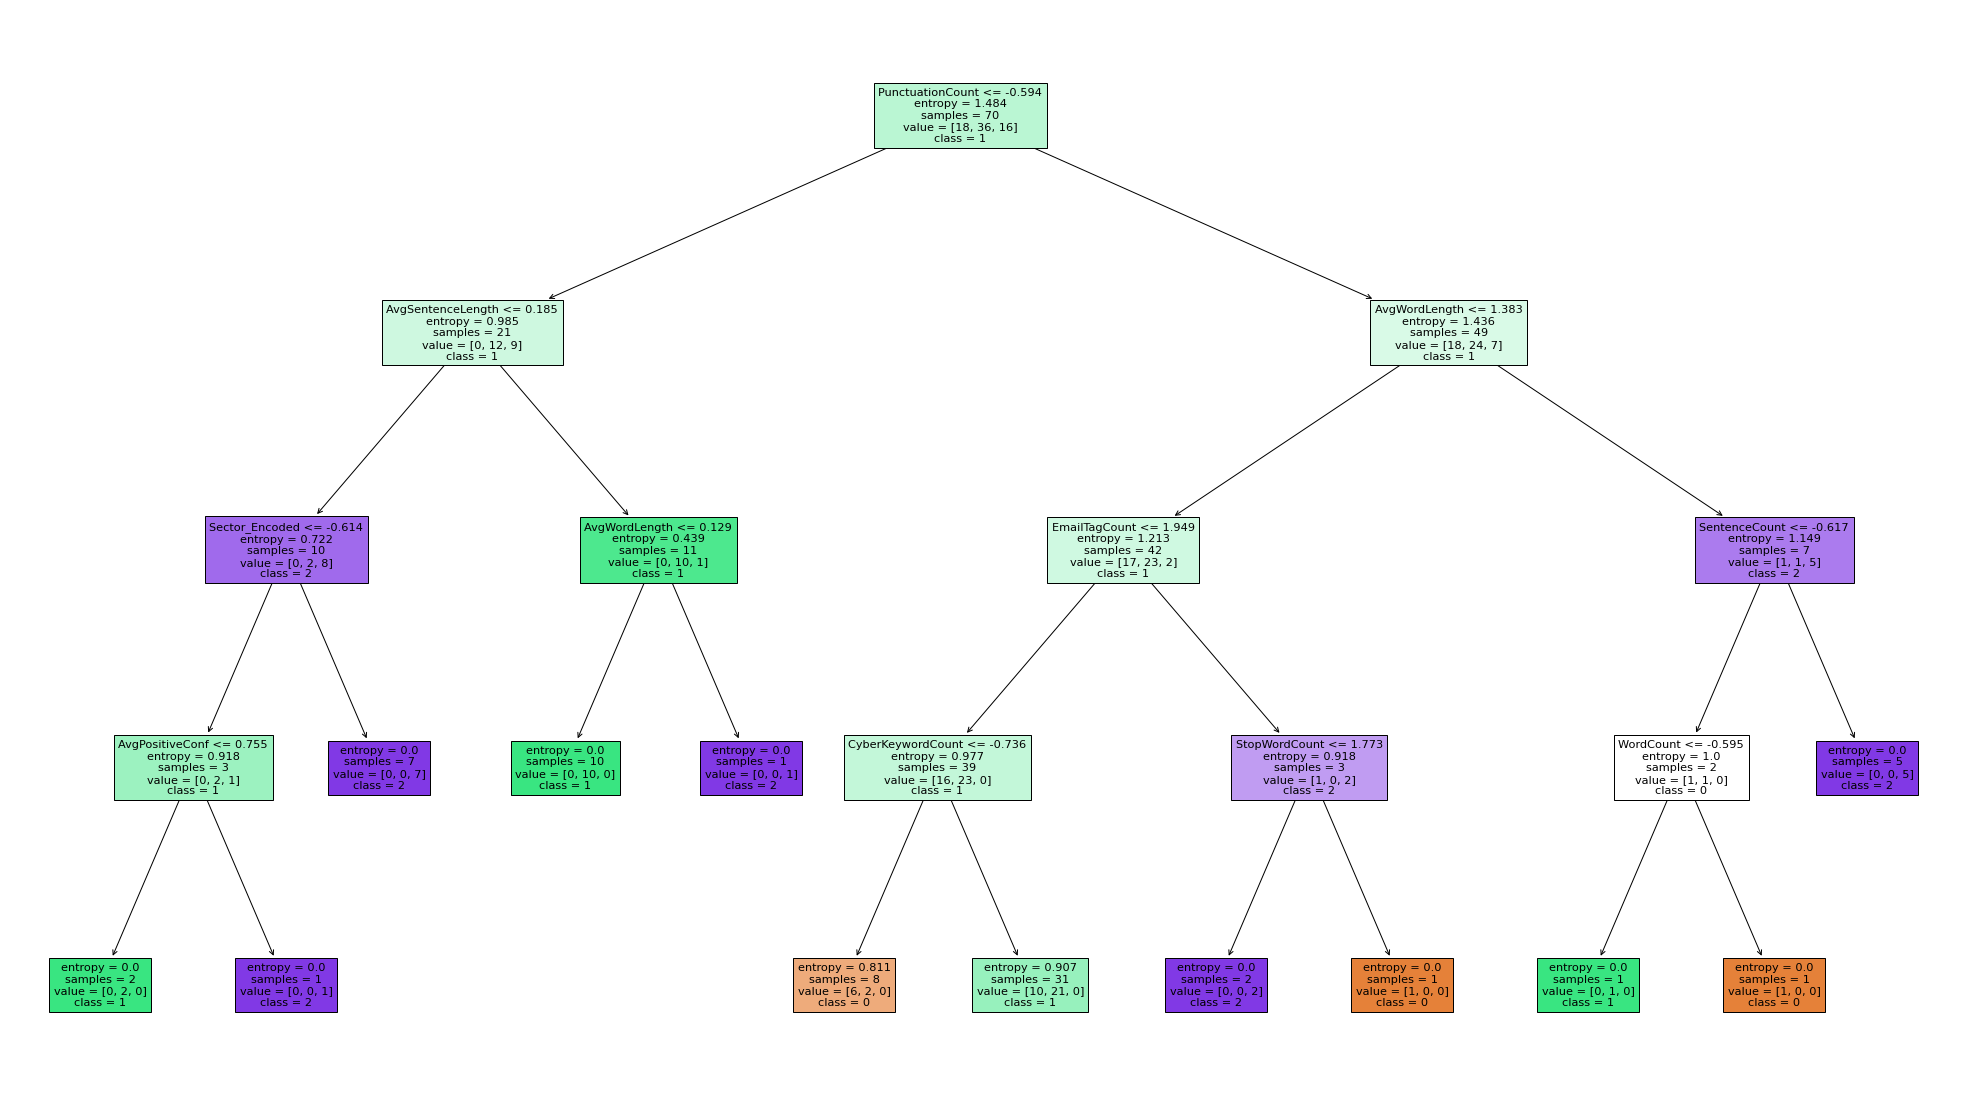

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth=4, criterion='entropy')
clf.fit(X_train_std, y_train)
y_pred = clf.predict(X_test_std)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

fig = plt.figure(figsize=(35,20))


t = tree.plot_tree(clf, feature_names=(#'AuthorMention', 'TitleMention', 'DataTypeCount', 
                                       'DataBreachSource_Encoded', 'Channel_Encoded', 'Sector_Encoded',
       'VaderSentiment_Encoded', 'PositiveCount', 'NegativeCount',
       'PosNegRatio', 'PosTotalRatio', 'AvgPositiveConf', 'AvgNegativeConf',
       'WordCount', 'SentenceCount', 'ReadingEase', 'Flesch-KincaidGrade',
       'HyperlinksCount', 'CyberKeywordCount', 'AuthorityKeywordCount',
       'FAQKeywordCount', 'AvgWordLength', 'AvgSentenceLength',
                                       'UniqueWordCount', 'StopWordCount', 'CharCount', 'PunctuationCount', 'EmailTagCount',
       ),
                   class_names=['0', '1', '2'],
                   filled=True)

#### 5. Random Forest Classifier

In [42]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=4)
clf.fit(X_train_std, y_train)
y_pred = clf.predict(X_test_std)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.50


#### 6. XGBoost

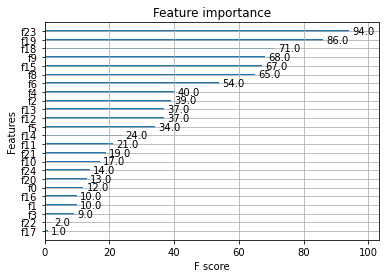

Accuracy: 0.57
Confusion Matrix:
[[ 3  2  0]
 [ 4 11  1]
 [ 1  5  3]]


In [43]:
# Ensemble
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

model = XGBClassifier()
model.fit(X_train_std, y_train)

# feature importance

plot_importance(model)
pyplot.show()

# Make predictions on the test data
y_pred = model.predict(X_test_std)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Print the classification report
# class_report = classification_report(y_test, y_pred, target_names=data.target_names)
# print("Classification Report:")
# print(class_report)

### Feature Selection

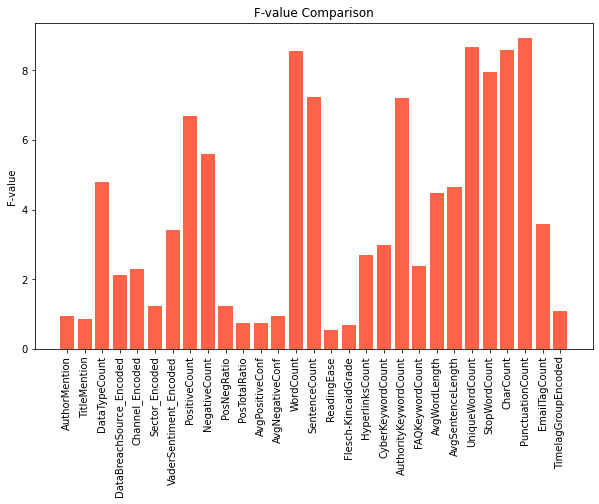

In [60]:
from sklearn.feature_selection import f_classif

X = df.drop(columns='LevelOfDetail')
y = df['LevelOfDetail']

# Create f_classif object to calculate F-value
f_value = f_classif(X, y)

plt.figure(figsize=(10,6))
plt.bar(x=X.columns, height=f_value[0], color='tomato')
plt.xticks(rotation='vertical')
plt.ylabel('F-value')
plt.title('F-value Comparison')
plt.show()

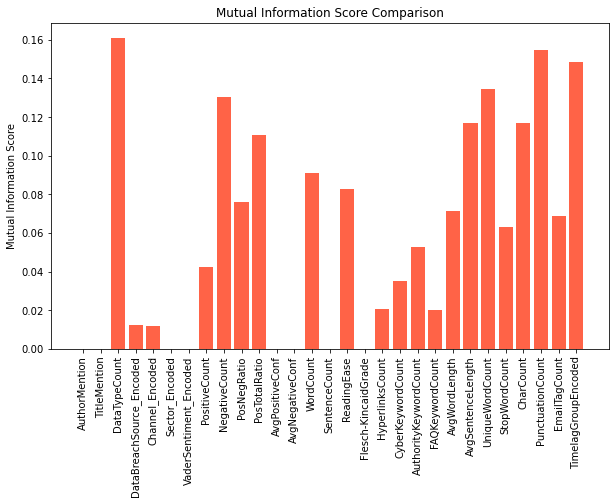

In [61]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

X = df.drop(columns='LevelOfDetail')
y = df['LevelOfDetail']

MI_score = mutual_info_classif(X, y, random_state=0)

plt.figure(figsize=(10,6))
plt.bar(x=X.columns, height=MI_score, color='tomato')

plt.xticks(rotation='vertical')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Score Comparison')

plt.show()

### Test different classifiers wihtout AuthorMention, TitleMention, DataTypeCount

#### Test 1

In [64]:
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

X = df.drop(columns='LevelOfDetail')
y = df['LevelOfDetail']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Create a dictionary of classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(kernel='linear', random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': xgboost.XGBClassifier(objective="multi:softmax", random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=20)
}

# Create pipelines for each classifier
pipelines = {}
for name, clf in classifiers.items():
    pipelines[name] = Pipeline([
        ('scaler', StandardScaler()),  # Standardize features (optional but often recommended)
        ('classifier', clf)
    ])
    
target_names = ['class 0', 'class 1', 'class 2']

# Train and evaluate each classifier
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=target_names)
    
    print(f"Classifier: {name}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(report)    
    
    print("="*40)

(80, 29) (80,) (20, 29) (20,)
Classifier: Random Forest
Accuracy: 0.55
Classification Report:
              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         4
     class 1       0.56      1.00      0.71        10
     class 2       1.00      0.17      0.29         6

    accuracy                           0.55        20
   macro avg       0.52      0.39      0.33        20
weighted avg       0.58      0.55      0.44        20

Classifier: Support Vector Machine
Accuracy: 0.55
Classification Report:
              precision    recall  f1-score   support

     class 0       0.33      0.25      0.29         4
     class 1       0.57      0.80      0.67        10
     class 2       0.67      0.33      0.44         6

    accuracy                           0.55        20
   macro avg       0.52      0.46      0.47        20
weighted avg       0.55      0.55      0.52        20

Classifier: Logistic Regression
Accuracy: 0.60
Classification Report:
 

#### Test 2 with SelectKBest included

In [47]:
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

X = df.drop(columns='LevelOfDetail')
y = df['LevelOfDetail']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Create a dictionary of classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(kernel='linear', random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': xgboost.XGBClassifier(objective="multi:softmax", random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=20)
}

# Create pipelines for each classifier
pipelines = {}
for name, clf in classifiers.items():
    pipelines[name] = Pipeline([
        ('feature_selector', SelectKBest(score_func=f_classif, k=25)), 
        ('scaler', StandardScaler()),  # Standardize features (optional but often recommended)
        ('classifier', clf)
    ])
    
target_names = ['class 0', 'class 1', 'class 2']

# Train and evaluate each classifier
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=target_names)
    
    print(f"Classifier: {name}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(report)    
        
    print("="*54)

(80, 25) (80,) (20, 25) (20,)
Classifier: Random Forest
Accuracy: 0.70
Classification Report:
              precision    recall  f1-score   support

     class 0       1.00      0.50      0.67         4
     class 1       0.62      1.00      0.77        10
     class 2       1.00      0.33      0.50         6

    accuracy                           0.70        20
   macro avg       0.88      0.61      0.65        20
weighted avg       0.81      0.70      0.67        20

Classifier: Support Vector Machine
Accuracy: 0.60
Classification Report:
              precision    recall  f1-score   support

     class 0       0.50      0.25      0.33         4
     class 1       0.60      0.90      0.72        10
     class 2       0.67      0.33      0.44         6

    accuracy                           0.60        20
   macro avg       0.59      0.49      0.50        20
weighted avg       0.60      0.60      0.56        20

Classifier: Logistic Regression
Accuracy: 0.50
Classification Report:
 

### Try SelectKBest

In [48]:
# Ref: https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py

from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC

X = df.drop(columns='LevelOfDetail')
y = df['LevelOfDetail']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

clf_selected = make_pipeline(
    SelectKBest(f_classif, k=4), MinMaxScaler(), LinearSVC()
)
clf_selected.fit(X_train, y_train)
print(
    "Classification accuracy after univariate feature selection: {:.3f}".format(
        clf_selected.score(X_test, y_test)
    )
)

svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()

(80, 25) (80,) (20, 25) (20,)
Classification accuracy after univariate feature selection: 0.600
